In [191]:
import os
import numpy as np
from sgfmill import sgf, sgf_moves

BOARD_SIZE = 19
NUM_TRAINING_GAMES = 1

In [8]:
# download:
# curl https://u-go.net/gamerecords/ | grep 'https://dl.u-go.net/gamerecords/' | grep zip | cut -d'"' -f 2 | awk '{ print "wget " $1 }' | sh
# extract:
# ls -l | awk '{ print "unzip " $9 }' | sh

In [75]:
game_files = os.popen("""find . -type f | grep '.sgf'""").read().split('\n')[:-1]

In [233]:
def training_point(board, move, color):
    board_array = torch.zeros((1, BOARD_SIZE, BOARD_SIZE), dtype=torch.float32)
    for p in board.list_occupied_points():
        board_array[0, p[1][0], p[1][1]] = -1.0 + 2 * int(p[0] == color)
    return board_array, move[0]*BOARD_SIZE+move[1]

training_game_files = game_files[:NUM_TRAINING_GAMES]
training_points = []
for i, game_file in enumerate(training_game_files):
    print('Processing %s/%s: %s' % (i, len(training_game_files), game_file))
    num_moves = 0
    with open(game_file) as f:
        contents = f.read().encode('ascii')
        game = sgf.Sgf_game.from_bytes(contents)
        board, plays = sgf_moves.get_setup_and_moves(game)
        for color, move in plays:
            if move is None: continue
            row, col = move
            tp = training_point(board, move, color)
            training_points.append(tp)
            board.play(row, col, color)
            num_moves += 1
print('Total training moves: %s' % len(training_points))

class GoDataset(data.Dataset):
    def __init__(self, training_points):
        self.training_points = training_points
    def __getitem__(self, index):
        return training_points[index][0], training_points[index][1]
    def __len__(self):
        return len(self.training_points)

dataset = GoDataset(training_points)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)
#test_loader = torch.utils.data.DataLoader(dataset, batch_size=1000, shuffle=True)

Processing 0/1: ./data/KGS2001/2001-12-26-7.sgf
Total training moves: 178


In [93]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [261]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=9, stride=1, padding=4)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=7, stride=1, padding=3)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.fc1 = nn.Linear(in_features=32*BOARD_SIZE*BOARD_SIZE, out_features=BOARD_SIZE*BOARD_SIZE)
        self.fc2 = nn.Linear(in_features=BOARD_SIZE*BOARD_SIZE, out_features=BOARD_SIZE*BOARD_SIZE)

    def forward(self, x):
        global i
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 32*BOARD_SIZE*BOARD_SIZE)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

def train(model, device, train_loader, optimizer, epoch):
    losses = []
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return losses

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (float(correct) / len(test_loader.dataset))

model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
device = torch.device("cpu")
losses = []
accuracies = []
for epoch in range(0, 1000):
    losses.extend(train(model, device, train_loader, optimizer, epoch))
    accuracies.append(test(model, device, train_loader))
    print(accuracies[-1])
losses = [item for sublist in losses for item in sublist]

Train Epoch: 0 [0/178 (0%)]	Loss: 5.884099
Train Epoch: 0 [160/178 (83%)]	Loss: 5.886787
0.0
Train Epoch: 1 [0/178 (0%)]	Loss: 5.880777
Train Epoch: 1 [160/178 (83%)]	Loss: 5.895573
0.011235955056179775
Train Epoch: 2 [0/178 (0%)]	Loss: 5.885187
Train Epoch: 2 [160/178 (83%)]	Loss: 5.880214
0.0056179775280898875
Train Epoch: 3 [0/178 (0%)]	Loss: 5.874560
Train Epoch: 3 [160/178 (83%)]	Loss: 5.876096
0.016853932584269662
Train Epoch: 4 [0/178 (0%)]	Loss: 5.876766
Train Epoch: 4 [160/178 (83%)]	Loss: 5.864841
0.016853932584269662
Train Epoch: 5 [0/178 (0%)]	Loss: 5.855231
Train Epoch: 5 [160/178 (83%)]	Loss: 5.847368
0.033707865168539325
Train Epoch: 6 [0/178 (0%)]	Loss: 5.831669
Train Epoch: 6 [160/178 (83%)]	Loss: 5.750313
0.028089887640449437
Train Epoch: 7 [0/178 (0%)]	Loss: 5.808489
Train Epoch: 7 [160/178 (83%)]	Loss: 5.895274
0.028089887640449437
Train Epoch: 8 [0/178 (0%)]	Loss: 5.714879
Train Epoch: 8 [160/178 (83%)]	Loss: 5.529486
0.028089887640449437
Train Epoch: 9 [0/178 (0%)

KeyboardInterrupt: 

In [257]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
params

4379779

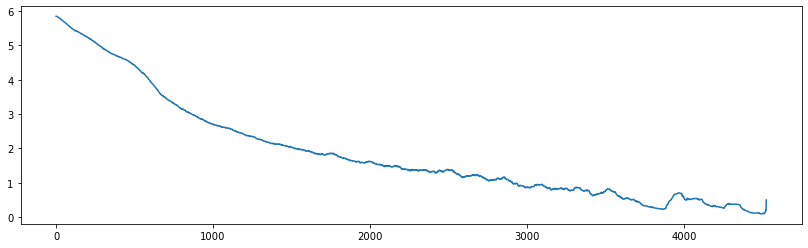

In [267]:
from matplotlib import pyplot as plt
%matplotlib inline  

def mean(li):
    return float(sum(li))/len(li)

plt.figure(figsize=(14, 4))
#plt.plot(losses)
plt.plot([mean(losses[i:i+100]) for i in range(len(losses))])

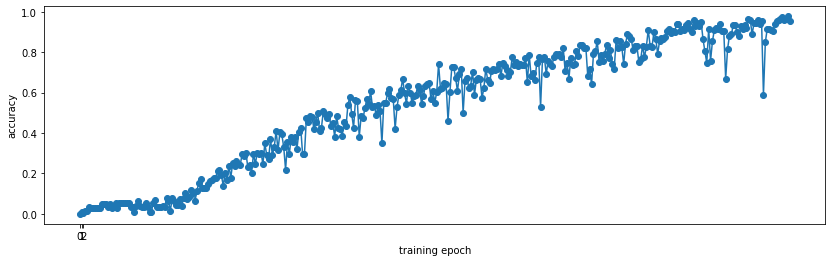

In [268]:
from matplotlib import pyplot as plt
plt.figure(figsize=(14, 4))
#plt.plot(losses)
plt.xticks([0, 1, 2])
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.plot(accuracies, marker='o')